# Retail project

## Part 1 - Data loading and preprocessing

In [1107]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st
from plotly import graph_objects as go

In [1108]:
try:
    retail = pd.read_csv('/Users/user/Downloads/retail_dataset_us.csv')
    
except:
    retail = pd.read_csv('/datasets/retail_dataset_us.csv')

In [1109]:
try:
    products = pd.read_csv('/Users/user/Downloads/product_codes_us.csv', sep = ';')
    
except:
    products = pd.read_csv('/datasets/product_codes_us.csv', sep = ';')

In [1110]:
datasets = ['retail', 'products']

In [1111]:
for d in datasets:
    print('-----{}-----'.format(d))
    print('           ')
    print(vars()[d].head())
    print('           ')
    print('Info:')
    print(vars()[d].info())
    print('           ')
    print('Shape:')
    print(vars()[d].shape)
    print('           ')
    print('Missing values:')
    print(vars()[d].isna().sum())
    print('           ')
    print('Duplicates:')
    print(vars()[d].duplicated().sum())
    print('          ')

-----retail-----
           
  purchaseid item_ID  Quantity         purchasedate  CustomerID  \
0     538280   21873        11  2016-12-10 12:50:00     18427.0   
1     538862   22195         0  2016-12-14 14:11:00     22389.0   
2     538855   21239         7  2016-12-14 13:50:00     22182.0   
3     543543   22271         0  2017-02-09 15:33:00     23522.0   
4     543812   79321         0  2017-02-13 14:40:00     23151.0   

   loyalty_program   ShopID  
0                0   Shop 3  
1                1   Shop 2  
2                1   Shop 3  
3                1  Shop 28  
4                1  Shop 28  
           
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105

### Description of the datasets: 

`retail_dataset_us.csv` contains:

- `purchaseId`
- `item_ID`
- `purchasedate`
- `Quantity` — the number of items in the purchase
- `CustomerID`
- `ShopID`
- `loyalty_program` — whether the customer is a member of the loyalty program

`product_codes_us.csv` contains:

- `productID`
- `price_per_one`

We have 1033 duplicated rows at the "retail" dataset. As this is realy very small part of our data (les han 1%), I will simply remove it: 

In [1112]:
retail.drop_duplicates(inplace=True)
retail.duplicated().sum()

0

More problamtic issue is the amount of rows with missing values at CustomerID column in the "retail" dataset. There are 36210 missing values there, more than 1/3 of our data! 

Let's investigate those rows:

In [1113]:
retail[retail['CustomerID'].isnull()].head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID
6,540468,22189,0,2017-01-07 13:55:00,NaN,0,Shop 0
7,541424,79321,1,2017-01-17 17:57:00,NaN,0,Shop 0
8,538883,22891,0,2016-12-14 15:56:00,NaN,0,Shop 0
11,541696,22197,4,2017-01-20 18:08:00,NaN,0,Shop 0
16,539744,22300,5,2016-12-21 15:21:00,NaN,0,Shop 0


It's seems that it might be that all the rows with missing value at the CustomerID column have no loyalty program, and their shop is Shop 0. Let's check it: 

In [1114]:
retail[retail['CustomerID'].isnull()]['loyalty_program'].sum()

0

Yep!

In [1115]:
retail[retail['CustomerID'].isnull()]['ShopID'].value_counts()

Shop 0     35952
Shop 6       127
Shop 25       53
Shop 21       14
Shop 23        2
Name: ShopID, dtype: int64

Not all 'CustomerID's missing values have Shop 0, But almost all of them. 

I think that missing values in the 'CustomerID' might mean random customers, with simply no customer id. That can explain also why they have no loyalty program. 
If that the case, We should have no purchase id's that have both ar row with a value in their 'CustomerID' cell, and a row with no value their. If we will find such purchase id's, it will disprove our theory.

Let's check it:

In [1116]:
x = retail.groupby('purchaseid')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
x

,purchaseid,CustomerID
0,536365,1
1,543373,1
2,543380,1
3,543379,1
4,543378,1
...,...,...
4889,539631,0
4890,542532,0
4891,542531,0
4892,542529,0


In [1117]:
x = x[x['CustomerID'] == 0]
x

,purchaseid,CustomerID
4146,C541492,0
4147,536995,0
4148,536920,0
4149,536991,0
4150,540683,0
...,...,...
4889,539631,0
4890,542532,0
4891,542531,0
4892,542529,0


In [1118]:
y = retail[retail['CustomerID'].isna()]
y

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID
6,540468,22189,0,2017-01-07 13:55:00,NaN,0,Shop 0
7,541424,79321,1,2017-01-17 17:57:00,NaN,0,Shop 0
8,538883,22891,0,2016-12-14 15:56:00,NaN,0,Shop 0
11,541696,22197,4,2017-01-20 18:08:00,NaN,0,Shop 0
16,539744,22300,5,2016-12-21 15:21:00,NaN,0,Shop 0
...,...,...,...,...,...,...,...
105325,536982,20719,69,2016-12-03 14:27:00,NaN,0,Shop 0
105326,540681,22227,1,2017-01-10 16:25:00,NaN,0,Shop 0
105327,538349,22625,0,2016-12-10 14:59:00,NaN,0,Shop 0
105329,540154,22134,3,2017-01-05 11:30:00,NaN,0,Shop 0


In [1119]:
z = y[y['purchaseid'].isin(x['purchaseid'])]
z

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID
6,540468,22189,0,2017-01-07 13:55:00,NaN,0,Shop 0
7,541424,79321,1,2017-01-17 17:57:00,NaN,0,Shop 0
8,538883,22891,0,2016-12-14 15:56:00,NaN,0,Shop 0
11,541696,22197,4,2017-01-20 18:08:00,NaN,0,Shop 0
16,539744,22300,5,2016-12-21 15:21:00,NaN,0,Shop 0
...,...,...,...,...,...,...,...
105325,536982,20719,69,2016-12-03 14:27:00,NaN,0,Shop 0
105326,540681,22227,1,2017-01-10 16:25:00,NaN,0,Shop 0
105327,538349,22625,0,2016-12-10 14:59:00,NaN,0,Shop 0
105329,540154,22134,3,2017-01-05 11:30:00,NaN,0,Shop 0


We see that all the purchase id's of the rows with the missing values at the 'CustomerID' column have no rows that have a value their. That's support our theory!

If that the case, I will fill in the missing values of the 'CustomerID' column simply with their puchase id (the value in the 'purchaseid' column). For these rows, the purchase id will function as customer id as well. We can know for sure that each purcase have been made by the same customer, so it's good that all rows with same purchase id will have the same customer id as well. It's true that it might be that the same rendom customer made several purchases (with different purchase id), but we have no way to know it. Filling in the missing customer id's with their purchase id seems like the best approach we have.

Let's do it:

In [1120]:
retail['CustomerID'] = retail['CustomerID'].fillna(retail['purchaseid'])
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   purchaseid       104302 non-null  object
 1   item_ID          104302 non-null  object
 2   Quantity         104302 non-null  int64 
 3   purchasedate     104302 non-null  object
 4   CustomerID       104302 non-null  object
 5   loyalty_program  104302 non-null  int64 
 6   ShopID           104302 non-null  object
dtypes: int64(2), object(5)
memory usage: 6.4+ MB


Good!

Now let's merge our data for best analysis:

In [1121]:
merged_data = pd.merge(retail, products, how="left", left_on='item_ID', right_on='productID')
merged_data.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,productID,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3,21873,0.42
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2,22195,1.65
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3,21239,0.72
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28,22271,2.55
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28,79321,0.00


In [1122]:
merged_data = merged_data.drop('productID', 1)
merged_data

C:\Users\user\AppData\Local\Temp/ipykernel_10960/78572246.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3,0.42
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2,1.65
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3,0.72
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28,2.55
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28,0.00
...,...,...,...,...,...,...,...,...
104297,538566,21826,1,2016-12-13 11:21:00,538566,0,Shop 0,1.25
104298,540247,21742,0,2017-01-05 15:56:00,21143.0,0,Shop 24,5.95
104299,538068,85048,1,2016-12-09 14:05:00,23657.0,1,Shop 16,6.95
104300,538207,22818,11,2016-12-10 11:33:00,18427.0,0,Shop 29,0.42


In [1123]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       104302 non-null  object 
 1   item_ID          104302 non-null  object 
 2   Quantity         104302 non-null  int64  
 3   purchasedate     104302 non-null  object 
 4   CustomerID       104302 non-null  object 
 5   loyalty_program  104302 non-null  int64  
 6   ShopID           104302 non-null  object 
 7   price_per_one    104302 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 7.2+ MB


Let's change the columns name in to one style:

In [1124]:
merged_data.columns = ['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id', 'loyalty_program', 'shop_id', 'price_per_one']
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_id      104302 non-null  object 
 1   item_id          104302 non-null  object 
 2   quantity         104302 non-null  int64  
 3   purchase_date    104302 non-null  object 
 4   customer_id      104302 non-null  object 
 5   loyalty_program  104302 non-null  int64  
 6   shop_id          104302 non-null  object 
 7   price_per_one    104302 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 7.2+ MB


Let's convert the purchase date column to date datatype:

In [1125]:
merged_data['purchase_date'] = pd.to_datetime(merged_data['purchase_date'])
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      104302 non-null  object        
 1   item_id          104302 non-null  object        
 2   quantity         104302 non-null  int64         
 3   purchase_date    104302 non-null  datetime64[ns]
 4   customer_id      104302 non-null  object        
 5   loyalty_program  104302 non-null  int64         
 6   shop_id          104302 non-null  object        
 7   price_per_one    104302 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 7.2+ MB


Some additional "cosmetic" changes and additions for more convinient analysis:

In [1126]:
merged_data['shop_id'] = merged_data['shop_id'].str.replace('Shop', '')
merged_data.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00


In [1127]:
merged_data['month'] = merged_data['purchase_date'].dt.to_period("M")
merged_data.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02


Finaly, let's add "revenue" column to our data:

In [1128]:
merged_data['revenue'] = merged_data['quantity']*merged_data['price_per_one']
merged_data

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00
...,...,...,...,...,...,...,...,...,...,...
104297,538566,21826,1,2016-12-13 11:21:00,538566,0,0,1.25,2016-12,1.25
104298,540247,21742,0,2017-01-05 15:56:00,21143.0,0,24,5.95,2017-01,0.00
104299,538068,85048,1,2016-12-09 14:05:00,23657.0,1,16,6.95,2016-12,6.95
104300,538207,22818,11,2016-12-10 11:33:00,18427.0,0,29,0.42,2016-12,4.62


2 notes about the revenue calculation:
1. We didn't add any data in regard to the revenue from the loyalty program fee ($20 per month). We will want to carry out our exploratory data analysis and test our first hypothesis based on product sales only. We will add this info later, when it will be needed.
2. We have no data about the discounts and gifts that's loyalty programs gives. As such, we should take in consideration that our revenue calculation is not fully accurate for the loyalty program purchases.

now our data is prepared for analysis!

## Part 2 - Exploratory data analysis:

#### Study of the parameters: 'price_per_one' and 'quantity' :
 - Plot histograms 
 - Study how outliers affect the form and readability of the histograms

In [1129]:
parameters = ['price_per_one', 'quantity']

-----price_per_one-----
          
count    104302.000000
mean          2.065705
std           3.726409
min           0.000000
25%           0.420000
50%           1.250000
75%           2.550000
max         175.000000
Name: price_per_one, dtype: float64
          
-----quantity-----
          
count    104302.000000
mean          7.883003
std         329.565540
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64
          


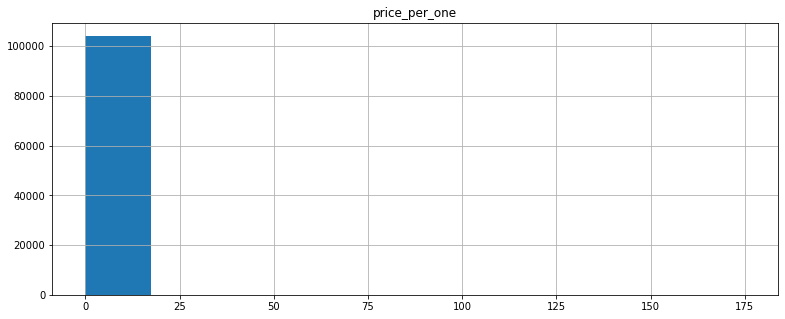

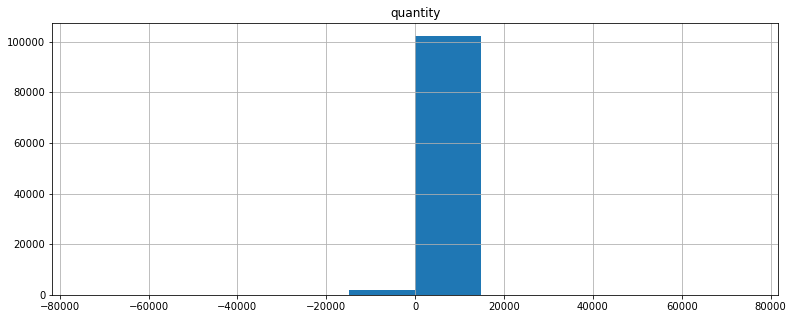

In [1130]:
for p in parameters:
    print('-----{}-----'.format(p))
    print('          ')
    print(merged_data[p].describe())
    print('          ')
    plt.figure(figsize=(13, 5))
    merged_data[p].hist()
    plt.title(p)

Let's identify and outliers for those 2 parameters, and see how much of our data  will be removed if we will remove them:

In [1131]:
border_list=[]
for p in parameters:
    Q1 = merged_data[p].quantile(0.25)
    Q3 = merged_data[p].quantile(0.75)
    IQR = Q3 - Q1
    min_iqr=Q1-1.5*IQR
    max_iqr=Q3+1.5*IQR
    border_list.append([p,min_iqr,max_iqr])

In [1132]:
border_list

[['price_per_one', -2.775, 5.744999999999999], ['quantity', -10.5, 17.5]]

In [1133]:
border_data=pd.DataFrame(border_list,columns=['parameter','min_border','max_border'])
border_data

,parameter,min_border,max_border
0,price_per_one,-2.775,5.745
1,quantity,-10.500,17.500


In [1134]:
filter_1=(merged_data['price_per_one']>-2.775)&(merged_data['price_per_one']<5.745)&(merged_data['quantity']>-10.5)&(merged_data['quantity']<17.5)
merged_data[filter_1]

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00
...,...,...,...,...,...,...,...,...,...,...
104295,537886,22158,7,2016-12-09 09:49:00,21339.0,0,13,0.00,2016-12,0.00
104296,540154,22134,3,2017-01-05 11:30:00,540154,0,0,0.42,2017-01,1.26
104297,538566,21826,1,2016-12-13 11:21:00,538566,0,0,1.25,2016-12,1.25
104300,538207,22818,11,2016-12-10 11:33:00,18427.0,0,29,0.42,2016-12,4.62


In [1135]:
(len(merged_data)-len(merged_data[filter_1]))/len(merged_data)

0.18169354374796265

If we remove the outliers, 18% of our data will be deleted. This is reasonable. 

Let's do it:

In [1136]:
merged_data = merged_data[filter_1]
merged_data.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00


Now let's study again the parameters at the filtered data:

-----price_per_one-----
          
count    85351.000000
mean         1.526004
std          1.317251
min          0.000000
25%          0.420000
50%          1.250000
75%          2.250000
max          5.550000
Name: price_per_one, dtype: float64
          
-----quantity-----
          
count    85351.000000
mean         3.222411
std          4.093204
min        -10.000000
25%          0.000000
50%          1.000000
75%          5.000000
max         17.000000
Name: quantity, dtype: float64
          


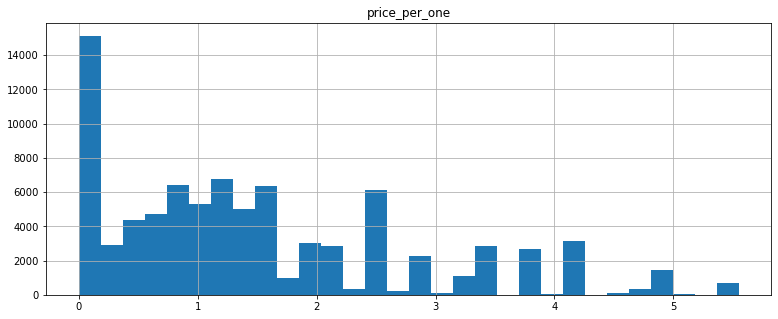

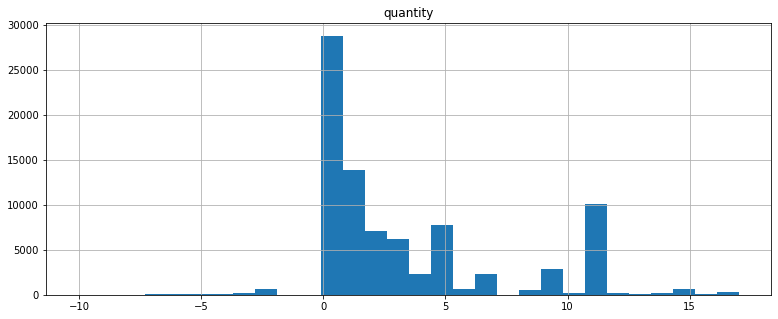

In [1137]:
for p in parameters:
    print('-----{}-----'.format(p))
    print('          ')
    print(merged_data[p].describe())
    print('          ')
    plt.figure(figsize=(13, 5))
    merged_data[p].hist(bins=30)
    plt.title(p)

Notes:
 - Cheap items (prices of USD0-1.5, especially up to price of USD0.2) seems to have much more sells. 
 - The majority of sells seems to have small quantities. 
 - There are negetive quantities. I assume these are cancellations/ credits.

#### Let's plot sales graphs:
 - Sales per month
 - Sales per outlet
 - Sales per product

For each of them we will plot 2 graphs:
 - Sales as the number of transactions
 - Sales as revenue
 
We will plot each graph for 3 datasets: 
1. The all data.
2. The data for loyalty program's purchases
3. The data for non loyalty program's purchases

First, let's create the 2 datasets of loyalty program's purchases and non loyalty program's purchases:

In [1138]:
lp_data = merged_data[merged_data['loyalty_program'] == 1]
lp_data.head() 

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00
5,538379,22965,0,2016-12-12 11:26:00,22805.0,1,20,1.85,2016-12,0.00


In [1139]:
nlp_data = merged_data[merged_data['loyalty_program'] == 0]
nlp_data.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62
6,540468,22189,0,2017-01-07 13:55:00,540468,0,0,2.31,2017-01,0.00
7,541424,79321,1,2017-01-17 17:57:00,541424,0,0,0.00,2017-01,0.00
8,538883,22891,0,2016-12-14 15:56:00,538883,0,0,3.75,2016-12,0.00
11,541696,22197,4,2017-01-20 18:08:00,541696,0,0,0.72,2017-01,2.88


       -----merged_data------


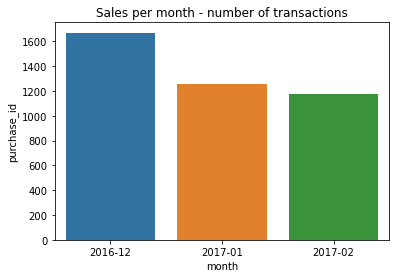

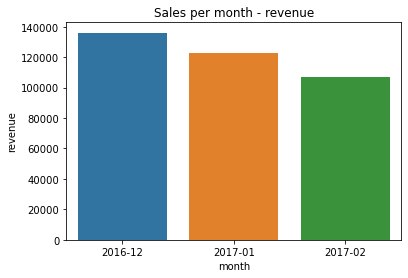

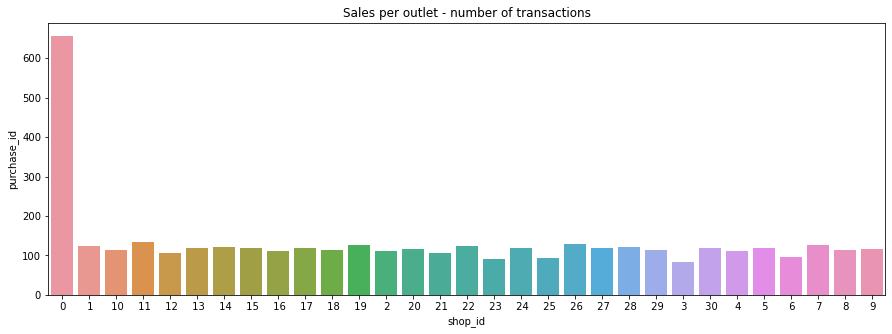

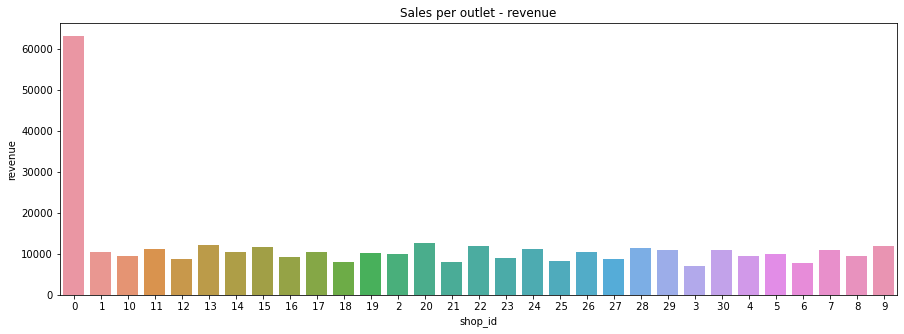

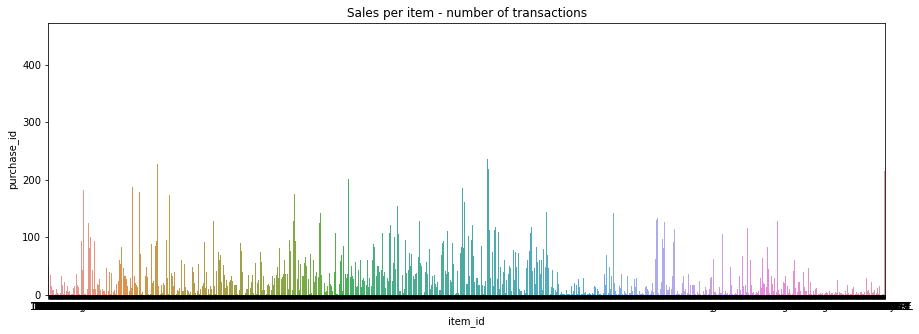

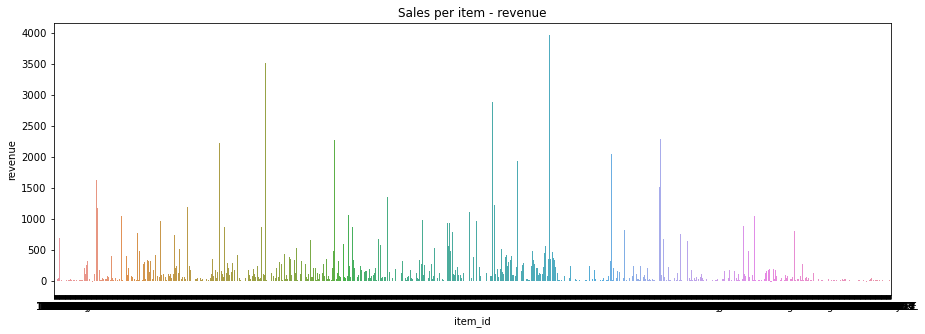

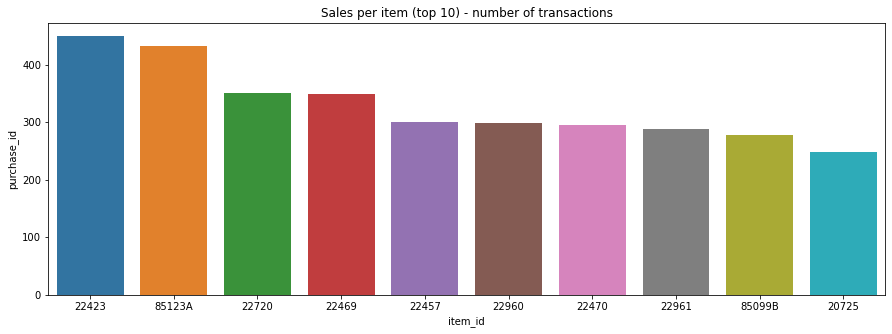

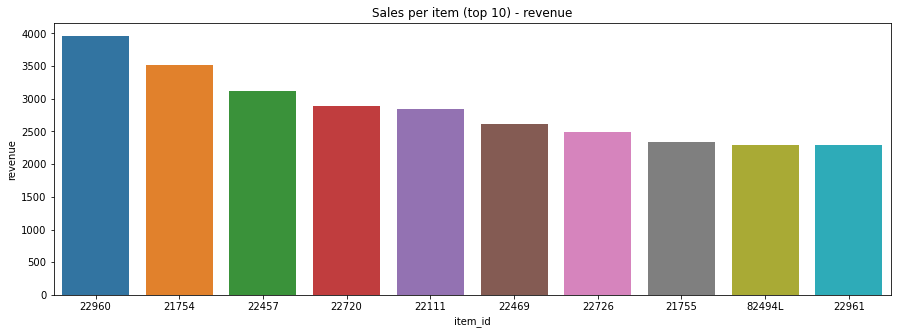

       -----lp_data------


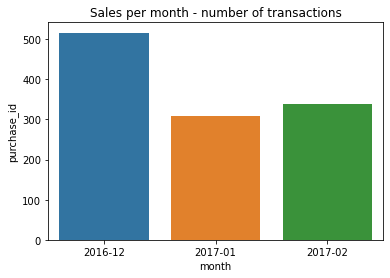

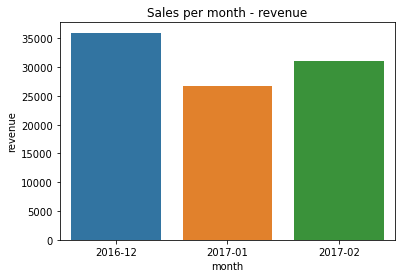

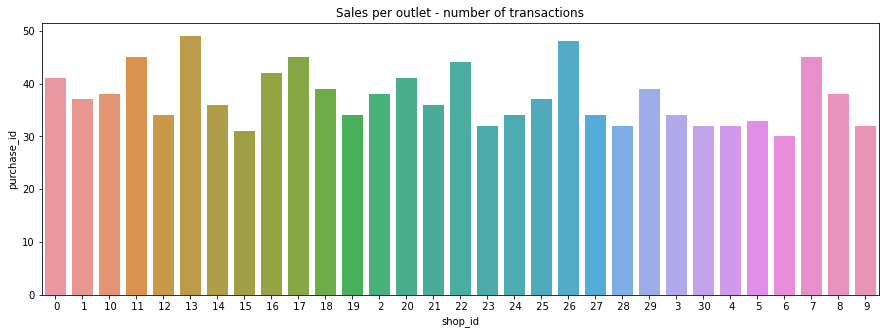

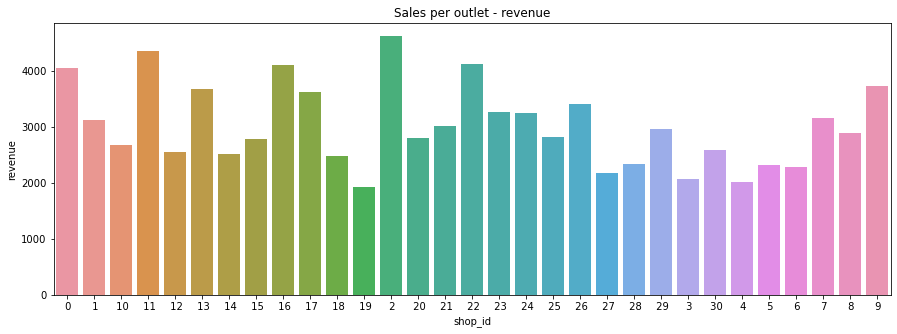

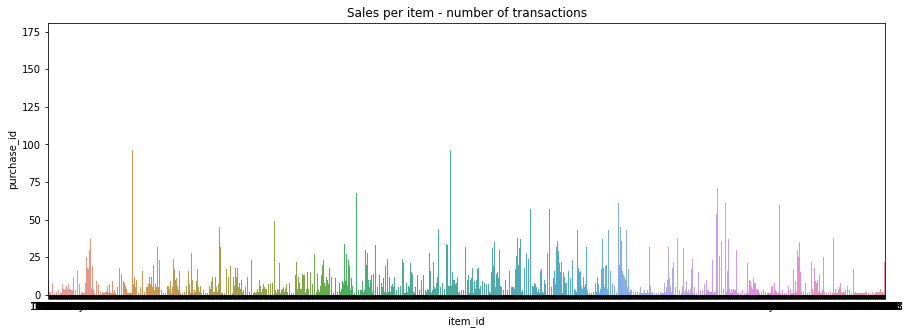

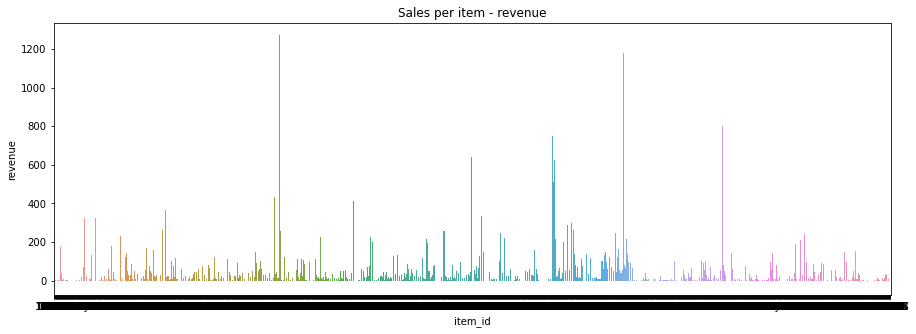

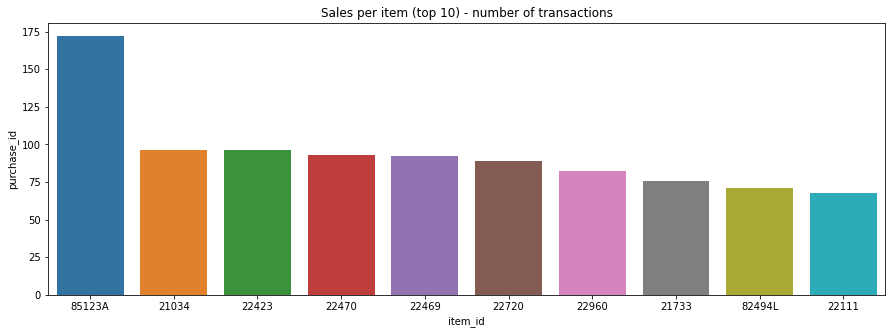

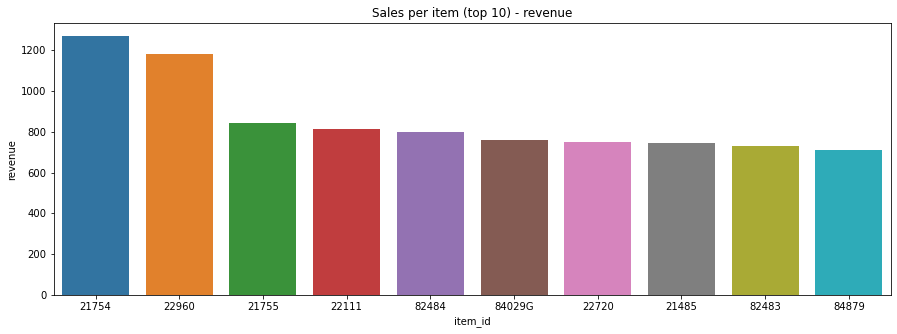

       -----nlp_data------


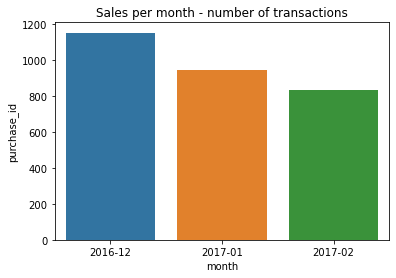

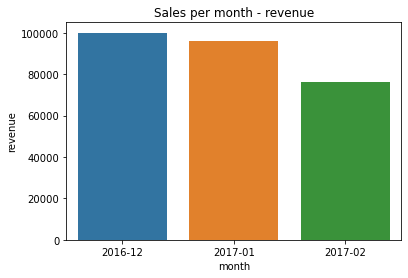

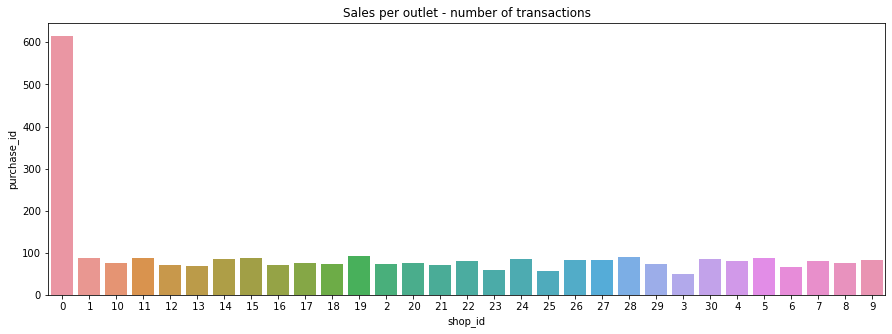

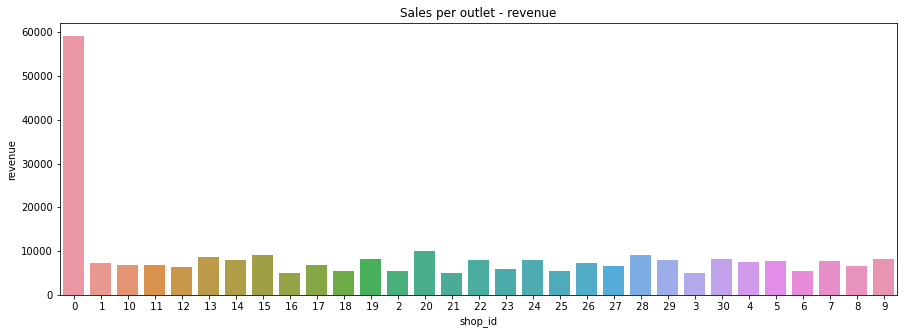

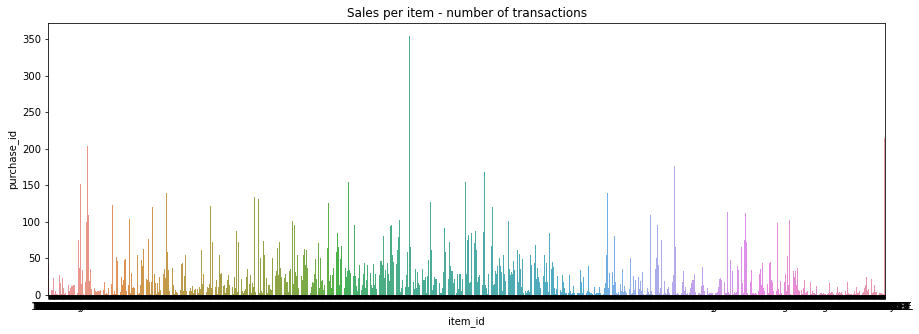

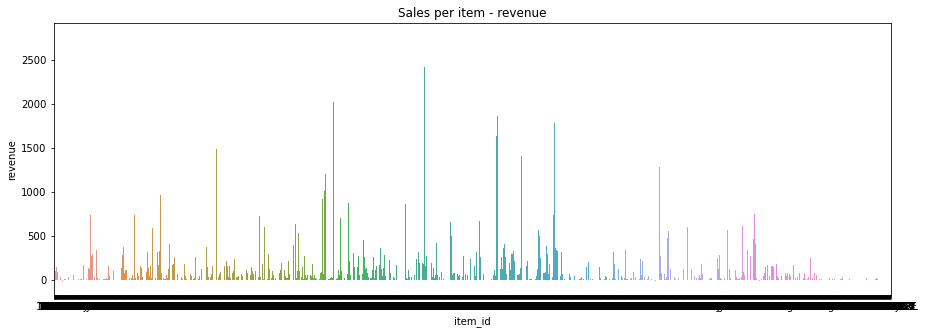

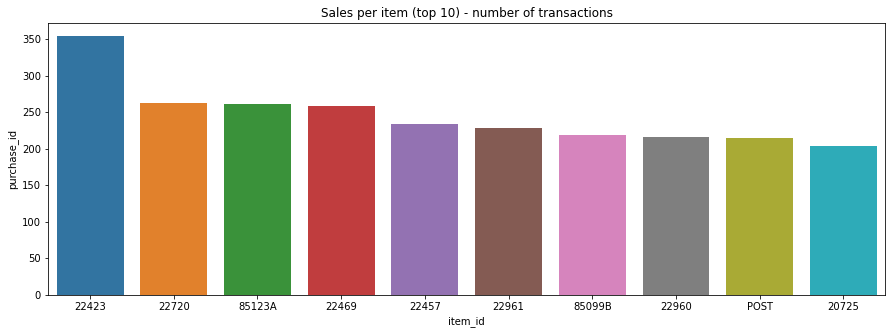

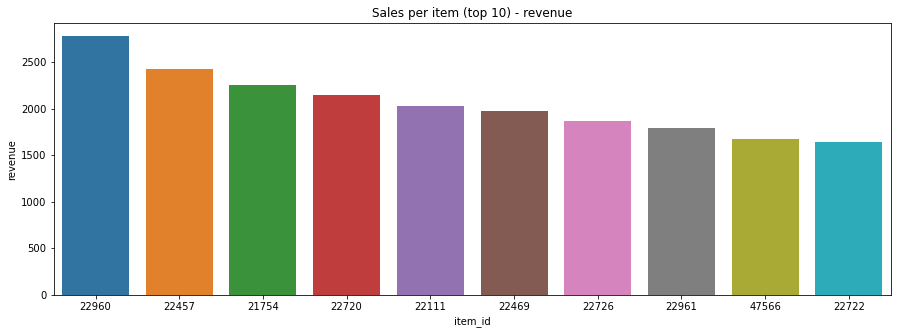

In [1140]:
datasets = ['merged_data', 'lp_data', 'nlp_data']

for d in datasets:
    print('       -----{}------'.format(d))
    y = vars()[d].groupby('month')['purchase_id'].nunique().reset_index()
    sns.barplot(x='month', y='purchase_id', data=y).set(title='Sales per month - number of transactions')
    plt.show()
    y = vars()[d].groupby('month')['revenue'].sum().reset_index()
    sns.barplot(x='month', y='revenue', data=y).set(title='Sales per month - revenue')
    plt.show()
    y = vars()[d].groupby('shop_id')['purchase_id'].nunique().reset_index()
    fig = plt.figure(figsize = (15, 5))
    sns.barplot(x='shop_id', y='purchase_id', data=y).set(title='Sales per outlet - number of transactions')
    plt.show()
    y = vars()[d].groupby('shop_id')['revenue'].sum().reset_index()
    fig = plt.figure(figsize = (15, 5))
    sns.barplot(x='shop_id', y='revenue', data=y).set(title='Sales per outlet - revenue')
    plt.show()
    y = vars()[d].groupby('item_id')['purchase_id'].nunique().reset_index()
    fig = plt.figure(figsize = (15, 5))
    sns.barplot(x='item_id', y='purchase_id', data=y).set(title='Sales per item - number of transactions')
    plt.show()
    y = vars()[d].groupby('item_id')['revenue'].sum().reset_index()
    fig = plt.figure(figsize = (15, 5))
    sns.barplot(x='item_id', y='revenue', data=y).set(title='Sales per item - revenue')
    plt.show()
    y = vars()[d].groupby('item_id')['purchase_id'].nunique().sort_values(ascending=False).reset_index().head(10)
    fig = plt.figure(figsize = (15, 5))
    sns.barplot(x='item_id', y='purchase_id', data=y).set(title='Sales per item (top 10) - number of transactions')
    plt.show()
    y = vars()[d].groupby('item_id')['revenue'].sum().sort_values(ascending=False).reset_index().head(10)
    fig = plt.figure(figsize = (15, 5))
    sns.barplot(x='item_id', y='revenue', data=y).set(title='Sales per item (top 10) - revenue')
    plt.show()

**Notes:**

Sales per month:
 - It's looks like sales are going down! 
 - The reason might be that the end of the year is high season for sales, and we need also to remember that February is a short month. 
 - Still, we need to keep an eye on sales graphs, and check that this is not a worrying trend.
 - For loyalty program there is a decrease in sales from December to January, but an increase from January to February.  

Sales per outlet:
 - Shop 0 is the best seller outlet. Is it an online shop? we should understand what kind of shop it, and what make it so good.
 - For loyalty program sales there is no so much difference between the outlets, The high dominance of shop 0 is for the non loyalty program sales.

Sales per item:
 - No spacial insights. It's reasonble to see what are the best seller products and maybe promote them more. For product that sell less, it's important to invetigate their profitability.
 
General note:
 - In regard to the revenue graphs, we should remember the notes above about the littles gaps we have in the revenue calculations for the loyalty program purchases.

## PART 3 - Assess the performance of the sales outlets

Here are the top 10 outlets in terms of revenue:

In [1141]:
x = merged_data.groupby('shop_id')['revenue'].sum().sort_values(ascending=False).reset_index().head(10)
x

,shop_id,revenue
0,0,63192.58
1,20,12755.38
2,13,12293.18
3,22,12015.65
4,9,11971.95
5,15,11795.85
6,28,11399.23
7,24,11185.52
8,11,11173.90
9,29,10967.73


In [1142]:
fig = go.Figure(data=[go.Pie(labels=x['shop_id'], values=x['revenue'])])
fig.show() 

Let's investigate the sales seasons and best sellers items for those 10 leading outlets:

In [1143]:
y = merged_data[merged_data['shop_id'].isin(x['shop_id'])]
y

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00
5,538379,22965,0,2016-12-12 11:26:00,22805.0,1,20,1.85,2016-12,0.00
6,540468,22189,0,2017-01-07 13:55:00,540468,0,0,2.31,2017-01,0.00
7,541424,79321,1,2017-01-17 17:57:00,541424,0,0,0.00,2017-01,0.00
...,...,...,...,...,...,...,...,...,...,...
104294,538349,22625,0,2016-12-10 14:59:00,538349,0,0,0.00,2016-12,0.00
104295,537886,22158,7,2016-12-09 09:49:00,21339.0,0,13,0.00,2016-12,0.00
104296,540154,22134,3,2017-01-05 11:30:00,540154,0,0,0.42,2017-01,1.26
104297,538566,21826,1,2016-12-13 11:21:00,538566,0,0,1.25,2016-12,1.25


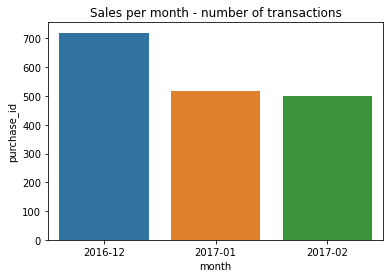

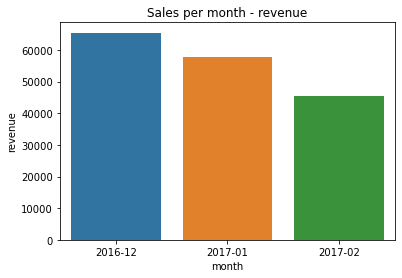

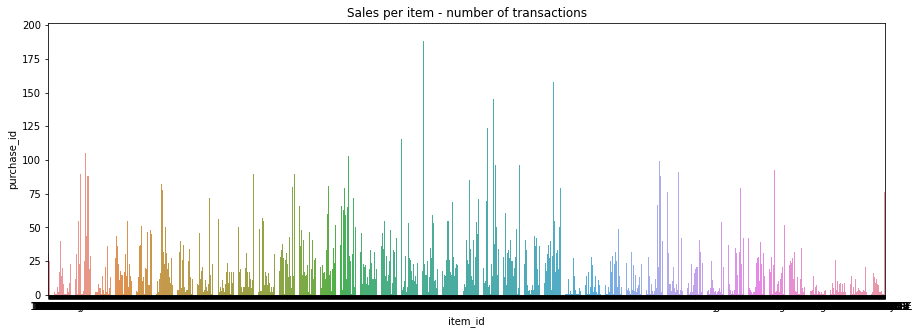

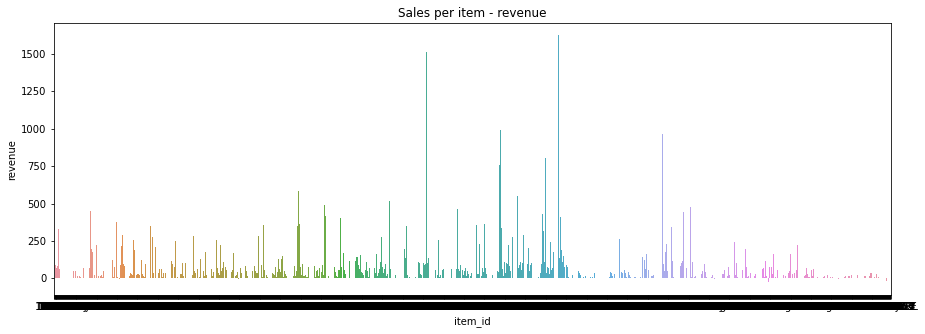

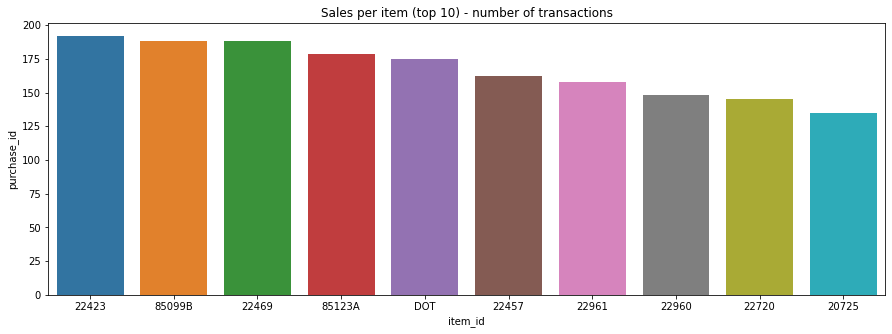

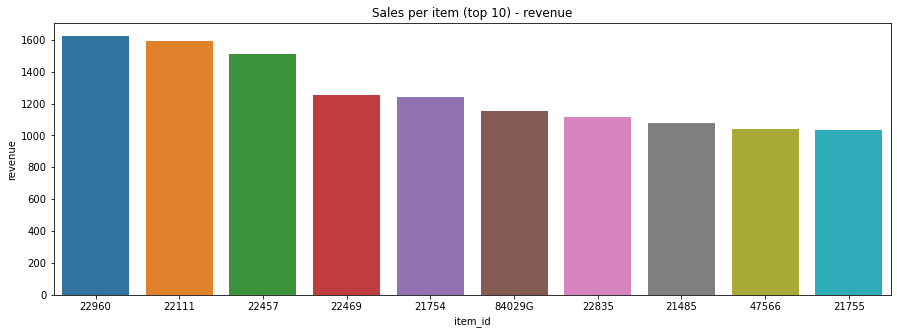

In [1144]:
z = y.groupby('month')['purchase_id'].nunique().reset_index()
sns.barplot(x='month', y='purchase_id', data=z).set(title='Sales per month - number of transactions')
plt.show()
z = y.groupby('month')['revenue'].sum().reset_index()
sns.barplot(x='month', y='revenue', data=z).set(title='Sales per month - revenue')
plt.show()
z = y.groupby('item_id')['purchase_id'].nunique().reset_index()
fig = plt.figure(figsize = (15, 5))
sns.barplot(x='item_id', y='purchase_id', data=z).set(title='Sales per item - number of transactions')
plt.show()
z = y.groupby('item_id')['revenue'].sum().reset_index()
fig = plt.figure(figsize = (15, 5))
sns.barplot(x='item_id', y='revenue', data=z).set(title='Sales per item - revenue')
plt.show()
z = y.groupby('item_id')['purchase_id'].nunique().sort_values(ascending=False).reset_index().head(10)
fig = plt.figure(figsize = (15, 5))
sns.barplot(x='item_id', y='purchase_id', data=z).set(title='Sales per item (top 10) - number of transactions')
plt.show()
z = y.groupby('item_id')['revenue'].sum().sort_values(ascending=False).reset_index().head(10)
fig = plt.figure(figsize = (15, 5))
sns.barplot(x='item_id', y='revenue', data=z).set(title='Sales per item (top 10) - revenue')
plt.show()

No special insights.

## Part 4 - Test statistical hypotheses

I would like to test the next hypothesis: avarage revenue for cheaper products differs from avg revenue for more expensive products. 

It seems to be clear that more expensive products will have a larger revenue, as they cost more...
But we need to keep in mind that in the end, revenue is also a function of the amount of sales, and it is possible that cheaper products are sold in such larger quantities that their average turnover is greater than the average turnover of an expensive product.

To check the hypothesis we need first to split our data in to "cheap" and "expensive" products.
First let's find out where should we place the border:

In [1145]:
merged_data['price_per_one'].describe()

count    85351.000000
mean         1.526004
std          1.317251
min          0.000000
25%          0.420000
50%          1.250000
75%          2.250000
max          5.550000
Name: price_per_one, dtype: float64

Let's split it this way: less than $2.1 will get "True" value in "cheap" column. else will get "False":

In [1146]:
merged_data['cheap'] = np.where(merged_data['price_per_one'] < 2.1, True, False)
merged_data.head()

C:\Users\user\AppData\Local\Temp/ipykernel_10960/2801990051.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue,cheap
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62,True
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00,True
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04,True
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00,False
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00,True


In [1147]:
cheap_items_revenue = merged_data[merged_data['cheap'] == True].groupby('item_id')['revenue'].sum().reset_index()
cheap_items_revenue

,item_id,revenue
0,10002,198.05
1,10080,0.85
2,10120,2.52
3,10123C,0.00
4,10124A,2.10
...,...,...
1806,DCGS0057,0.00
1807,DCGS0072,0.00
1808,DCGS0074,0.00
1809,M,11.97


In [1148]:
expensive_items_revenue = merged_data[merged_data['cheap'] == False].groupby('item_id')['revenue'].sum().reset_index()
expensive_items_revenue

,item_id,revenue
0,15044A,88.50
1,15044B,97.35
2,15044C,50.15
3,15044D,100.30
4,15056BL,935.55
...,...,...
854,DCGSSBOY,0.00
855,DCGSSGIRL,6.58
856,DOT,-5.02
857,S,-28.00


Here are our null and alternative hypothesis:

    H0: Average revenue for cheap items and expensive items is the same
    H1: Average revenue for cheap items and expensive items is different

In [1149]:
st.levene(cheap_items_revenue['revenue'], expensive_items_revenue['revenue'], center='mean')

LeveneResult(statistic=144.6677726731406, pvalue=1.7303177753302157e-32)

In [1150]:
alpha=0.05
result1 = st.ttest_ind(cheap_items_revenue['revenue'], expensive_items_revenue['revenue'], equal_var=False)
print('p-value: ', result1.pvalue)

if (result1.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

cheap_mean = cheap_items_revenue['revenue'].mean()
expensive_mean = expensive_items_revenue['revenue'].mean()

print('Cheap items revenue mean:', cheap_mean)
print('Expensive items revenue mean:', expensive_mean)

p-value:  3.0432885136718774e-11
We reject the null hypothesis
Cheap items revenue mean: 104.24565433462168
Expensive items revenue mean: 206.44429569266595


So expensive items produce more revenue! The conclusions from it might differ - put more effort in develop those kind of items, maybe increase prices...  
Interesting!

Let's plot also a correltion plot between the price per item, and the revenue it produced:

<AxesSubplot:xlabel='price_per_one', ylabel='revenue'>

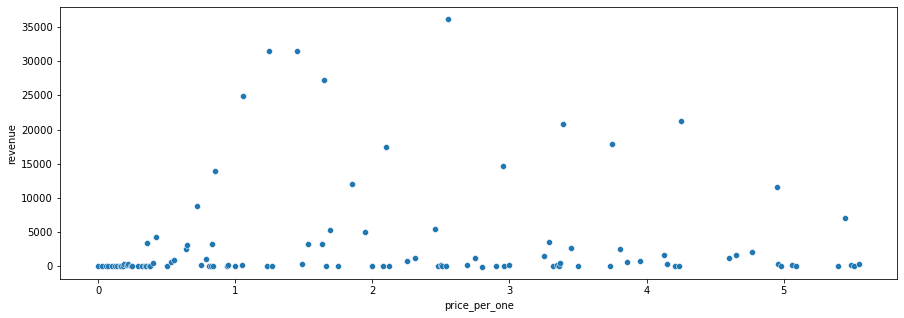

In [1151]:
all_items_revenue = merged_data.groupby('price_per_one')['revenue'].sum().reset_index()
fig = plt.figure(figsize = (15, 5))
sns.scatterplot(x='price_per_one', y='revenue', data=all_items_revenue)

Another hypothesis I would like to test is: Does members of the loyalty program have different monthly revenue in avg?

To answer this question I will want to first add the data for the loyalty program fee ($20 per month).
As we don't know when each customer have been registrated to the program, we will follow the assumption that every month he has a purchase that have been registrated as loyalty program purchase, was a month he was a part of the program and payed the fee. 

Let's calculate accordingaly: 

In [1152]:
merged_data['month'] = merged_data['purchase_date'].dt.to_period("M")
merged_data.head()

C:\Users\user\AppData\Local\Temp/ipykernel_10960/3370111403.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue,cheap
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62,True
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00,True
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04,True
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00,False
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00,True


In [1153]:
x = merged_data[merged_data['loyalty_program'] == 1].groupby('customer_id')['month'].unique().reset_index()
x

,customer_id,month
0,22005.0,[2017-01]
1,22006.0,"[2016-12, 2017-01]"
2,22011.0,[2017-02]
3,22018.0,[2017-02]
4,22028.0,[2017-02]
...,...,...
542,23938.0,[2016-12]
543,23939.0,"[2017-01, 2016-12]"
544,23948.0,[2016-12]
545,23956.0,[2017-01]


In [1154]:
x = x.explode('month')
x

,customer_id,month
0,22005.0,2017-01
1,22006.0,2016-12
1,22006.0,2017-01
2,22011.0,2017-02
3,22018.0,2017-02
...,...,...
543,23939.0,2016-12
544,23948.0,2016-12
545,23956.0,2017-01
546,23962.0,2017-01


In [1155]:
x['revenue'] = 20
x

,customer_id,month,revenue
0,22005.0,2017-01,20
1,22006.0,2016-12,20
1,22006.0,2017-01,20
2,22011.0,2017-02,20
3,22018.0,2017-02,20
...,...,...,...
543,23939.0,2016-12,20
544,23948.0,2016-12,20
545,23956.0,2017-01,20
546,23962.0,2017-01,20


In [1156]:
cols = ['customer_id', 'month']
x = x.assign(purchase_id=x[cols].astype(str).apply(''.join, 1))
x['item_id'] = 'lp'
x['quantity'] = 1
x['purchase_date'] = x['month']
x['loyalty_program'] = 1
x['shop_id'] = 'lp'
x['price_per_one'] = 1
x

,customer_id,month,revenue,purchase_id,item_id,quantity,purchase_date,loyalty_program,shop_id,price_per_one
0,22005.0,2017-01,20,22005.02017-01,lp,1,2017-01,1,lp,1
1,22006.0,2016-12,20,22006.02016-12,lp,1,2016-12,1,lp,1
1,22006.0,2017-01,20,22006.02017-01,lp,1,2017-01,1,lp,1
2,22011.0,2017-02,20,22011.02017-02,lp,1,2017-02,1,lp,1
3,22018.0,2017-02,20,22018.02017-02,lp,1,2017-02,1,lp,1
...,...,...,...,...,...,...,...,...,...,...
543,23939.0,2016-12,20,23939.02016-12,lp,1,2016-12,1,lp,1
544,23948.0,2016-12,20,23948.02016-12,lp,1,2016-12,1,lp,1
545,23956.0,2017-01,20,23956.02017-01,lp,1,2017-01,1,lp,1
546,23962.0,2017-01,20,23962.02017-01,lp,1,2017-01,1,lp,1


In [1157]:
x = x[['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id', 'loyalty_program', 'shop_id', 'price_per_one', 'revenue', 'month']]
x

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,revenue,month
0,22005.02017-01,lp,1,2017-01,22005.0,1,lp,1,20,2017-01
1,22006.02016-12,lp,1,2016-12,22006.0,1,lp,1,20,2016-12
1,22006.02017-01,lp,1,2017-01,22006.0,1,lp,1,20,2017-01
2,22011.02017-02,lp,1,2017-02,22011.0,1,lp,1,20,2017-02
3,22018.02017-02,lp,1,2017-02,22018.0,1,lp,1,20,2017-02
...,...,...,...,...,...,...,...,...,...,...
543,23939.02016-12,lp,1,2016-12,23939.0,1,lp,1,20,2016-12
544,23948.02016-12,lp,1,2016-12,23948.0,1,lp,1,20,2016-12
545,23956.02017-01,lp,1,2017-01,23956.0,1,lp,1,20,2017-01
546,23962.02017-01,lp,1,2017-01,23962.0,1,lp,1,20,2017-01


Let's add this data to our merged_data table:

In [1158]:
merged_data = merged_data.append(x)
merged_data

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,month,revenue,cheap
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,3,0.42,2016-12,4.62,True
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,2,1.65,2016-12,0.00,True
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,3,0.72,2016-12,5.04,True
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,28,2.55,2017-02,0.00,False
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,28,0.00,2017-02,0.00,True
...,...,...,...,...,...,...,...,...,...,...,...
543,23939.02016-12,lp,1,2016-12,23939.0,1,lp,1.00,2016-12,20.00,NaN
544,23948.02016-12,lp,1,2016-12,23948.0,1,lp,1.00,2016-12,20.00,NaN
545,23956.02017-01,lp,1,2017-01,23956.0,1,lp,1.00,2017-01,20.00,NaN
546,23962.02017-01,lp,1,2017-01,23962.0,1,lp,1.00,2017-01,20.00,NaN


Now let's create the relevent tables for chacking our question above: 

In [1159]:
lp_users_monthly_revenue = merged_data[merged_data['loyalty_program'] == 1].groupby(['customer_id', 'month'])['revenue'].sum().reset_index()
lp_users_monthly_revenue

,customer_id,month,revenue
0,22005.0,2017-01,119.29
1,22006.0,2016-12,232.44
2,22006.0,2017-01,284.68
3,22011.0,2017-02,73.84
4,22018.0,2017-02,24.16
...,...,...,...
778,23939.0,2017-01,162.99
779,23948.0,2016-12,49.50
780,23956.0,2017-01,20.00
781,23962.0,2017-01,41.52


In [1160]:
nlp_users_monthly_revenue = merged_data[merged_data['loyalty_program'] == 0].groupby(['customer_id', 'month'])['revenue'].sum().reset_index()
nlp_users_monthly_revenue

,customer_id,month,revenue
0,18026.0,2016-12,338.93
1,18026.0,2017-01,218.51
2,18027.0,2016-12,0.00
3,18027.0,2017-01,0.00
4,18029.0,2017-02,177.80
...,...,...,...
2065,C544581,2017-02,-5.60
2066,C544583,2017-02,-5.60
2067,C544587,2017-02,-2.00
2068,C544589,2017-02,-2.00


Here are our null and alternative hypothesis:

    H0: Average monthly revenue for the loyalty program users and non loyalty program users is the same
    H1: Average monthly revenue for the loyalty program users and non loyalty program users is different

In [1161]:
st.levene(lp_users_monthly_revenue['revenue'], nlp_users_monthly_revenue['revenue'], center='mean')

LeveneResult(statistic=31.691250740205632, pvalue=1.9832526349404145e-08)

In [1162]:
alpha=0.05
result1 = st.ttest_ind(lp_users_monthly_revenue['revenue'], nlp_users_monthly_revenue['revenue'], equal_var=False)
print('p-value: ', result1.pvalue)

if (result1.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

lp_mean = lp_users_monthly_revenue['revenue'].mean()
nlp_mean = nlp_users_monthly_revenue['revenue'].mean()

print('Loyalty program users monthly revenue mean:', lp_mean)
print('Non loyalty program users monthly revenue mean:', nlp_mean)

p-value:  0.20342106200334167
We can't reject the null hypothesis
Loyalty program users monthly revenue mean: 139.8116475095784
Non loyalty program users monthly revenue mean: 131.55169565217375


So we can't say that monthly revenue for the loyalty program users and non loyalty program users is different, and remember that the real revenue for the loyalty program purchases is even lower than the data we have (as we don't have the discounts info).

It's worth while to put an effort in attracting users to the loyalty program? Maybe not. Or maybe we should put much more effort in thinking how to make our loyalty program much more profitable. 

## Summary and conclusions:

In this project we have analysed the sales of the building-material retailer Home World.
We have preprocessed our data:
 - Filled in missing values.
 - Removed duplicates.
 - Made needed datatypes changes.  
 - Merged all the relevant data from our 2 given datasets.
 - Calculated and added revenue data.
 
We have carried out an exploratory data analysis:
 - Studied the parameters: 'price_per_one' and 'quantity'. 
 - Removed outliers.
 - ploted graphs of sales per month, per outlet, per item - for the whole data, and for loyalty program Vs non loyalty program purchases.
 - additional study for the sales in leading outlets.

We have tested 2 statistical hypotheses: 
1. Average revenue for cheap items and expensive items is different - We have confirmed it. Expensive items brings in more revenue. 
2. Average monthly revenue for the loyalty program users and non loyalty program users is different - We couldn't confirm this hypothesis.

**In my opinion, we can draw the following conclusions and recommendations from our research:**
 - The end of the year is a good season for sales. Nevertheless, we need to alert managers that our sales are going down, and look in to it more carefully.
 - Shop 0 is the best seller outlet. We should understand what kind of shop it, and what make it so good. We should also figure out why it's have much more relevance to non loyalty program sales. We should invest more in this shop.
 - Loyalty program seems to work not so well. There is no better revenue for loyalty program customers, even if we take in consideration their fee. We must understand how can we make this program more profitable, or maybe cancel it.
 - Expensive items bring in more revenue. We should invest in developing high level, expensive items.
<br>Maybe we should increase prices in general.

Link to presentation: https://drive.google.com/file/d/1iqcISk_rBIfW9OMeKGbSX_okAeQmn9eq/view?usp=sharing

Link to dashboard: https://public.tableau.com/app/profile/elik.goldberg/viz/Retailprojectdashboard/Dashboard1?publish=yes

Sources I have used while working: 
1. https://stackoverflow.com/questions/51778480/remove-certain-string-from-entire-column-in-pandas-dataframe
<br>For the code of dropping the "shop" string from the values at the 'Shop_id' column


2. https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html
<br>Refreshing my memory about how to groupby 2 columns


3. https://www.statology.org/seaborn-title/
<br>For adding title to my barplots


4. https://www.codegrepper.com/code-examples/python/new+line+in+jupyter+notebook+markdown
<br>To get a new line in markdown cells


5. https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
<br>To create the diagrams of sells per date


6. https://realpython.com/pandas-merge-join-and-concat/
<br>To merge the data